# Modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l

In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torchvision
from torch import nn
from d2l import torch as d2l
import torch
import torchvision.transforms as transforms
import torch.optim as optim

In [ ]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

Epoch 1, Train Loss: 2.3598, Train Accuracy: 0.1975, Validation Accuracy: 0.0000
Epoch 2, Train Loss: 2.0514, Train Accuracy: 0.2746, Validation Accuracy: 0.0000
Epoch 3, Train Loss: 1.8790, Train Accuracy: 0.3404, Validation Accuracy: 0.0000
Epoch 4, Train Loss: 1.7377, Train Accuracy: 0.3772, Validation Accuracy: 0.0000
Epoch 5, Train Loss: 1.6933, Train Accuracy: 0.3996, Validation Accuracy: 0.0000
Epoch 6, Train Loss: 1.5402, Train Accuracy: 0.4542, Validation Accuracy: 0.0000
Epoch 7, Train Loss: 1.4835, Train Accuracy: 0.4833, Validation Accuracy: 0.0000
Epoch 8, Train Loss: 1.4319, Train Accuracy: 0.4888, Validation Accuracy: 0.0000
Epoch 9, Train Loss: 1.3267, Train Accuracy: 0.5335, Validation Accuracy: 0.0000
Epoch 10, Train Loss: 1.3630, Train Accuracy: 0.5335, Validation Accuracy: 0.0000
Epoch 11, Train Loss: 1.2969, Train Accuracy: 0.5536, Validation Accuracy: 0.0000
Epoch 12, Train Loss: 1.2200, Train Accuracy: 0.5770, Validation Accuracy: 0.0000
Epoch 13, Train Loss: 1.1

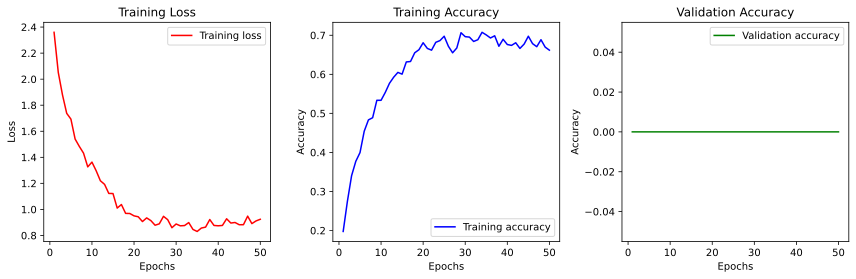

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import os
import shutil
import collections
import math
import pandas as pd
import matplotlib.pyplot as plt

def get_net(num_classes=10):
    net = torchvision.models.resnet18(pretrained=True)
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net

# Definir transformações para dados de treino e teste
transform_train = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

# Função para ler labels do arquivo CSV
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict((name, label) for name, label in tokens)

# Funções para reorganizar os dados de treino e teste
def copyfile(filename, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

# Função de treinamento com Fine-Tuning
def train_fine_tuning(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = optim.Adam([
        {'params': net.parameters(), 'lr': lr, 'weight_decay': wd}
    ])
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, step_size=lr_period, gamma=lr_decay)
    loss = nn.CrossEntropyLoss()
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    # Listas para registrar as métricas
    train_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
        scheduler.step()

        train_loss = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Avaliar a acurácia no conjunto de validação
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in valid_iter:
                X, y = X.to(devices[0]), y.to(devices[0])
                outputs = net(X)
                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        valid_acc = correct / total if total > 0 else 0
        valid_accuracies.append(valid_acc)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}')

    return train_losses, train_accuracies, valid_accuracies

# Carregar e preparar os dados
batch_size = 128
valid_ratio = 0.1
data_dir = d2l.download_extract('cifar10_tiny')
reorg_cifar10_data(data_dir, valid_ratio)

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# Obter o modelo e treiná-lo
net = get_net(num_classes=10)
devices = d2l.try_all_gpus()
num_epochs, lr, wd, lr_period, lr_decay = 50, 0.001, 1e-4, 10, 0.1
train_losses, train_accuracies, valid_accuracies = train_fine_tuning(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

# Plotar as métricas
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, valid_accuracies, 'g', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Salvar o modelo ajustado
torch.save(net.state_dict(), 'cifar10_resnet18_fine_tuned.pth')

In [ ]:
!pip install flask

In [ ]:
!pip install flask-ngrok
!pip install flask
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from flask import Flask, request, jsonify
from PIL import Image
import io
import threading

model_path = '/content/cifar10_resnet18_fine_tuned.pth'

# Função para obter a rede modificada
def get_net(num_classes=10):
    net = torchvision.models.resnet18(pretrained=True)
    # Substituir a última camada totalmente conectada para combinar com o número de classes
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net

# Função para carregar o modelo
def load_model(path):
    net = get_net(num_classes=10)
    net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    net.eval()
    return net

# Função para fazer a inferência
def predict(image, model, device):
    transform = transforms.Compose([
        transforms.Resize(40),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Carregar o modelo treinado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(model_path).to(device)

# Definir os nomes das classes do CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Configurar a API Flask
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict_image():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part in the request'}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No file selected for uploading'}), 400
    try:
        image = Image.open(io.BytesIO(file.read()))
        predicted_class = predict(image, model, device)
        class_name = class_names[predicted_class]
        return jsonify({'class_id': predicted_class, 'class_name': class_name})
    except Exception as e:
        return jsonify({'error': str(e)}), 500

def run_flask():
    app.run(port=5003)

flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5003
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
import requests

# URL do servidor Flask
flask_url = 'http://127.0.0.1:5003/predict'
image_path = '/content/cachorro.jpg'  # Substitua pelo caminho da sua imagem

with open(image_path, 'rb') as f:
    files = {'file': f}
    response = requests.post(flask_url, files=files)
    print(response.json())


INFO:werkzeug:127.0.0.1 - - [27/May/2024 14:56:47] "POST /predict HTTP/1.1" 200 -


{'class_id': 4, 'class_name': 'deer'}
